In [1]:
import tempfile
import warnings

import dask
import icechunk
import matplotlib.style as mplstyle
import numpy as np
import xarray as xr
from distributed import Client
from icechunk.distributed import merge_sessions

from ocr.chunking_config import ChunkingConfig

mplstyle.use('fast')

In [2]:
client = Client(n_workers=12)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://cluster-igbxg.dask.host/jupyter/proxy/8787/status,
Dashboard: https://cluster-igbxg.dask.host/jupyter/proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 30.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39981,Workers: 12
Dashboard: https://cluster-igbxg.dask.host/jupyter/proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 30.15 GiB
Comm: tcp://127.0.0.1:35401,Total threads: 1
Dashboard: https://cluster-igbxg.dask.host/jupyter/proxy/45107/status,Memory: 2.51 GiB
Nanny: tcp://127.0.0.1:40947,


In [3]:
config = ChunkingConfig()
config

<POLYGON ((2327640 221280, 2327640 3267390, -2362380 3267390, -2362380 22128...>

In [4]:
storage = icechunk.s3_storage(
    bucket='carbonplan-ocr',
    prefix='input/fire-risk/tensor/USFS/RDS-2022-0016-02_all_vars_merge_icechunk',
    from_env=True,
)


repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')
ds = xr.open_zarr(session.store, consolidated=False, chunks={})[['BP']]
ds['BP'] = ds['BP'].astype('float32')
ds['BP'].encoding = {}

In [12]:
zarr_chunks = config.chunks
template = xr.Dataset(config.ds.coords).drop_vars('spatial_ref')
template['BP'] = xr.DataArray(
    dask.array.zeros(
        (config.ds.sizes['y'], config.ds.sizes['x']),
        dtype='float32',
        chunks=-1,
    ),
    dims=('y', 'x'),
)


In [15]:
storage = icechunk.local_filesystem_storage(tempfile.TemporaryDirectory().name)
repo = icechunk.Repository.create(storage)
session = repo.writable_session('main')

template.to_zarr(
    session.store,
    compute=False,
    mode='w',
    encoding={
        'BP': {'chunks': ((config.chunks['x'], config.chunks['y'])), 'fill_value': np.nan}
    },  # IMPORTANT
    consolidated=False,
)

session.commit('template')

'0G8Q05E5FRFN04KDEPCG'

In [16]:
((config.chunks['x'], config.chunks['y']))

(6000, 4500)

In [17]:
ZARR_CHUNK_SIZE

(6000, 4500)

In [18]:
def get_commit_messages_ancestry(repo: icechunk.repository) -> list:
    return [commit.message for commit in list(repo.ancestry(branch='main'))]


@dask.delayed
def insert_region(session: icechunk.Session, subset_ds: xr.Dataset):
    subset_ds.to_zarr(
        session.store,
        region='auto',
        consolidated=False,
    )
    return session


def write_regions(ds: xr.Dataset, session: icechunk.Session, region_dict: dict):
    commit_messages = get_commit_messages_ancestry(repo)
    already_commited_messages = [
        msg
        for message in commit_messages
        for msg in (message.split(',') if ',' in message else [message])
    ]
    uncommited_dict = {
        key: subset for key, subset in region_dict.items() if key not in already_commited_messages
    }
    if not uncommited_dict:
        # maybe add logging
        warnings.warn(f'No new chunks to commit!: {uncommited_dict}')
    else:
        # IMPORTANT! we need to pass in subsets, not the entire dataset to get pickled.
        ds_subsets_uncommited = [
            ds.isel(x=x_slice, y=y_slice) for y_slice, x_slice in uncommited_dict.values()
        ]

        with session.allow_pickling():
            tasks = [
                insert_region(session=session, subset_ds=subset_ds)
                for subset_ds in ds_subsets_uncommited
            ]
            # we could persist or w/e here
            sessions = dask.compute(*tasks, scheduler=client)

        # grabs only the dict keys / region_ids
        region_ids = [key for key in uncommited_dict.keys()]
        commit_region_ids = ','.join(region_ids)

        session = merge_sessions(session, *sessions)
        session.commit(f'{commit_region_ids}')

# Write CA BBOX chunks

In [19]:
ca_bbox = config.bbox_from_wgs84(-125.277100, 32.374502, -113.961182, 41.951126)
ca_chunks = config.get_chunks_for_bbox(ca_bbox)
chunk_slices_ca = config.chunks_to_slices(ca_chunks)

repo = icechunk.Repository.open(storage)
session = repo.writable_session('main')
write_regions(ds=ds, session=session, region_dict=chunk_slices_ca)

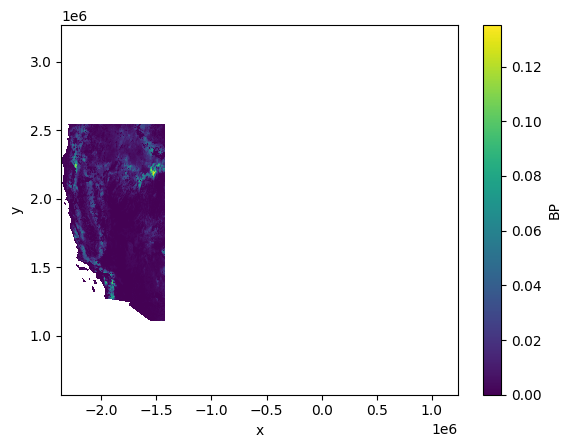

In [20]:
repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')
rtds = xr.open_zarr(session.store, consolidated=False, chunks={})[['BP']]
rtds.isel(y=slice(0, 90000), x=slice(0, 120000)).coarsen(x=10, y=10, boundary='trim').mean()[
    'BP'
].plot()

## Write OR BBOX chunks 


In [13]:
or_bbox = config.bbox_from_wgs84(-124.958496, 41.963324, -116.477051, 46.208322)

or_chunks = config.get_chunks_for_bbox(or_bbox)
chunk_slices_or = config.chunks_to_slices(or_chunks)


repo = icechunk.Repository.open(storage)
session = repo.writable_session('main')
write_regions(ds=ds, session=session, region_dict=chunk_slices_or)

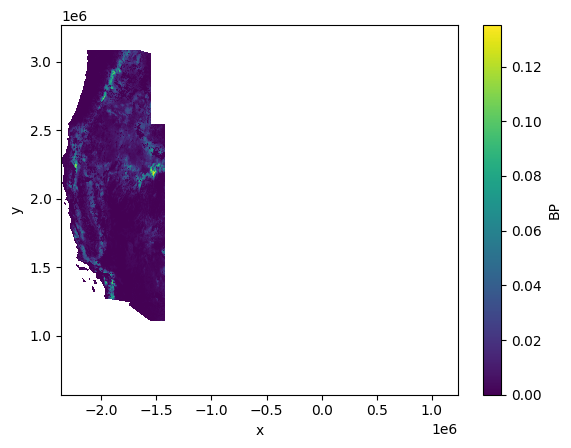

In [14]:
repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')
rtds = xr.open_zarr(session.store, consolidated=False, chunks={})[['BP']]
rtds.isel(y=slice(0, 90000), x=slice(0, 120000)).coarsen(x=10, y=10, boundary='trim').mean()[
    'BP'
].plot()